# Tutorial 11b - Ray Path Failure Classification Model

### Introduction
In this notebook, we will build a classification model using logistic regression to predict whether a given ray will trace successfully through a Cooke triplet lens. Successful in this context means the ray traces from object space and onto the image surface without experiencing total internal reflection or missing a lens surface entirely.

Specifically, this notebook will:

1. Model a Cooke triplet lens system in Optiland.
2. Generate random rays and trace them through the system. Inputs are reported as the initial ray properties and the output is a flag indicating if raytracing was successful.
3. Train a logistic regression model to predict whether a ray will successfully trace through the lens system.
4. Assess the performance of the logistic regression model.
5. Visualize the results using various plots.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from optiland.rays import RealRays
from optiland.samples.objectives import CookeTriplet

## Step 1: Setting Up the Lens System with Optiland

We will model a Cooke triplet lens system in Optiland. Below is the code to define and view the lens system.

In [2]:
lens = CookeTriplet()

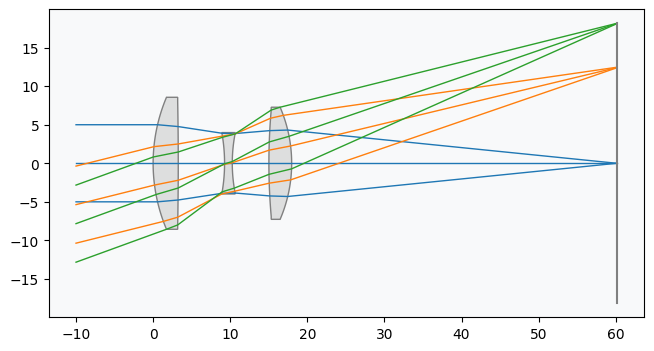

In [3]:
lens.draw()

## Step 2: Data generation

In this step, we generate random rays and trace them through the Cooke triplet lens system. The inputs are the initial ray properties, and the output is a flag indicating if ray tracing was successful. The generated data will be used to train the logistic regression model.

In [4]:
def get_random_rays(num_rays, seed=42):
    """Generate random rays."""
    np.random.seed(seed)

    # get random positions
    theta = np.random.uniform(0, 2 * np.pi, size=num_rays)
    r = 15.0 * np.sqrt(np.random.uniform(0, 1, size=num_rays))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.full(num_rays, -10.0)  # starting ray point in object space

    # get random directions
    v = np.random.randn(3, num_rays)
    v /= np.linalg.norm(v, axis=0)
    v[2] = np.abs(v[2])  # Ensure positive z-direction
    L, M, N = v

    # define wavelength and intensity as constants
    intensity = np.ones(num_rays)
    wavelength = np.full(num_rays, 0.5876)

    return RealRays(x, y, z, L, M, N, intensity, wavelength)

In [5]:
def trace_random_rays(num_rays):
    # get random rays
    rays_in = get_random_rays(num_rays)

    # build input array
    inputs = np.column_stack([rays_in.x, rays_in.y, rays_in.L, rays_in.M, rays_in.N])

    # trace rays and return
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rays_out = lens.surface_group.trace(rays_in)

    # build output array - simply checks if ray reached the image plane
    outputs = np.isfinite(rays_out.x)

    # merge into pandas dataframe
    data = pd.DataFrame(inputs, columns=["x", "y", "L", "M", "N"])
    data["success"] = outputs.astype(int)

    return data

We choose to trace 3 million rays through our system. This is only limited by available computational resources.

In [6]:
num_rays = 3_000_000

data = trace_random_rays(num_rays)

## Step 3: Exploratory Data Analysis (EDA)

In this step, we will perform exploratory data analysis (EDA) to understand the characteristics of the dataset. EDA helps in identifying patterns, detecting anomalies, and checking assumptions with the help of summary statistics and graphical representations.

We will cover the following aspects in our EDA:

1. **Data Overview**: Display the first few rows of the dataset to get a sense of the data structure.
2. **Class Distribution**: Check the distribution of the target variable to understand the class imbalance.
3. **Summary Statistics**: Generate summary statistics to understand the dataset’s distribution.
4. **Correlation Analysis**: Calculate and visualize the correlation matrix to identify relationships between features.
5. **Visualizations**: Create various plots to visualize the data distribution and relationships between features.

Let's start with displaying the first few rows of the dataset.

In [7]:
data.head()

,x,y,L,M,N,success
0,-9.126309,9.179203,0.032585,0.457168,0.888783,0
1,7.150769,-2.287995,-0.494729,-0.003432,0.869040,0
2,-1.401754,-12.337153,0.546859,-0.833323,0.080731,0
3,-2.599085,-1.855077,0.295361,0.749453,0.592522,0
4,7.484345,11.165942,-0.092561,0.310504,0.946055,0


We view the distribution of the success column. We see that the dataset is significantly imbalanced i.e., 96% of rays result in a failure. We will address this imbalance later on during model training.

In [8]:
print("Class Distribution:\n", data["success"].value_counts(normalize=True))

Class Distribution:
 success
0    0.960771
1    0.039229
Name: proportion, dtype: float64


We can view the distribution of the data columns using the `describe` method.

In [9]:
data.describe()

,x,y,L,M,N,success
count,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,-3.901070e-03,-1.086166e-03,-3.628822e-05,1.074950e-04,4.999451e-01,3.922933e-02
std,7.498685e+00,7.501070e+00,5.774254e-01,5.773347e-01,2.886514e-01,1.941402e-01
min,-1.499983e+01,-1.499879e+01,-9.999989e-01,-9.999988e-01,1.148959e-07,0.000000e+00
25%,-6.058138e+00,-6.067575e+00,-5.001888e-01,-4.999813e-01,2.496066e-01,0.000000e+00
50%,-7.308889e-03,5.082629e-04,-3.691050e-04,1.897821e-04,5.000599e-01,0.000000e+00
75%,6.050669e+00,6.057551e+00,5.000351e-01,4.998886e-01,7.496616e-01,0.000000e+00
max,1.499931e+01,1.499919e+01,9.999978e-01,9.999993e-01,9.999992e-01,1.000000e+00


We compute the correlation between variables and plot a heat map. This shows that the most critical parameter is the ray N direction cosine. This is logical, as rays pointing along the optical axis are intituitively more likely to trace successfully through the system. Rays that point away from the optical axis, and therefore have a small N direction cosine, are unlikely to trace through the system.

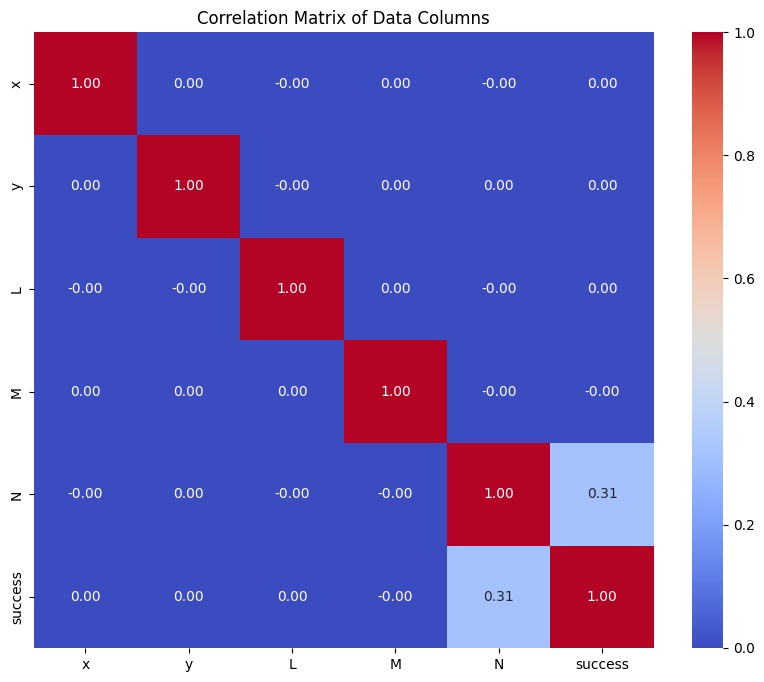

In [10]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Data Columns")
plt.show()

## Step 4: Model Building

In this step, we will build a logistic regression model to predict whether a ray will successfully trace through the Cooke triplet lens system. The process involves the following steps:

1. **Data Preparation**: Split the dataset into training and testing sets, and handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique).
2. **Feature Scaling**: Standardize the features to ensure that they have a mean of 0 and a standard deviation of 1.
3. **Model Training**: Train a logistic regression model using the prepared training data.

In [11]:
X = data.drop(columns=["success"])
y = data["success"]

In [12]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

Here, we use SMOTE (Synthetic Minority Oversampling Technique) to handle our imbalanced dataset.

SMOTE is used to address the issue of imbalanced datasets, where certain classes are underrepresented, such as in our dataset. This imbalance can lead to biased models that perform poorly on the minority class. For example, in a significantly imbalanced dataset, a model that always predicts the majority class would show reasonable results, on average. We want to avoid this behavior.

SMOTE works by generating synthetic samples for the minority class by interpolating between existing minority class samples. This helps to balance the class distribution and improve the model's performance on the minority class.

In [13]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Standardize the features. Note that we fit the standard scaler on the training data and then apply the same transformation to the test data. This avoids data leakage.

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Finally, we train the logistic regression model.

In [15]:
# Train a logistic regression model
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight="balanced",
)  # Add class_weight='balanced' if not using SMOTE
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## Step 5: Model Performance Assessment

In this step, we will evaluate the performance of our logistic regression model using various metrics and visualizations. The following aspects will be covered:

1. **Classification Report**: This report provides key metrics such as precision, recall, F1-score, and support for each class.
2. **Confusion Matrix**: A confusion matrix will be displayed to show the number of true positives, true negatives, false positives, and false negatives.
3. **Accuracy**: The overall accuracy of the model will be calculated.
4. **F1 Score**: The F1 score, which is the harmonic mean of precision and recall, will be computed.
5. **ROC AUC Score**: The Area Under the Receiver Operating Characteristic Curve (ROC AUC) will be calculated to evaluate the model's ability to distinguish between classes.
6. **ROC Curve**: The ROC curve will be plotted to visualize the trade-off between the true positive rate and false positive rate.
7. **Precision-Recall Curve**: The precision-recall curve will be plotted to visualize the trade-off between precision and recall.

First, we make predictions using the test dataset.

In [16]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[
    :,
    1,
]  # Probabilities for the positive class (1)

We then generate a classification report, which gives an overview of the model performance on the test data. We can see that the performance is worse for the "1" class i.e., predicting when a ray is successful. In general, recall for both classes is 0.9 or more.

In [17]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    576462
           1       0.29      0.98      0.45     23538

    accuracy                           0.90    600000
   macro avg       0.64      0.94      0.70    600000
weighted avg       0.97      0.90      0.93    600000



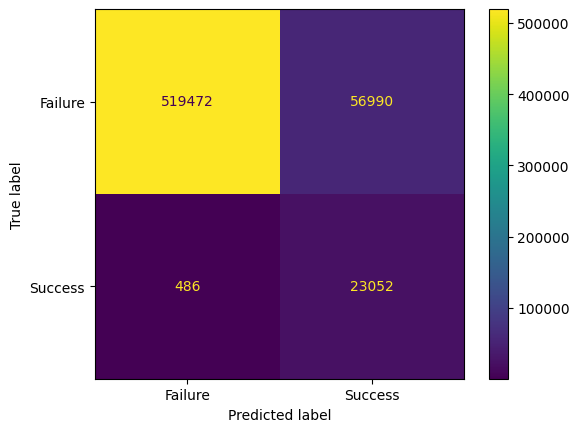

In [18]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Failure", "Success"],
)
disp.plot()
plt.show()

Compute a few useful metrics.

In [19]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Accuracy: 0.9042
F1 Score: 0.4451
ROC AUC: 0.9641


The Receiver Operating Characteristic (ROC) curve is a graphical representation of a classification model's performance. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The TPR is also known as sensitivity or recall, while the FPR is the proportion of actual negatives that are incorrectly identified as positives.

Key points about the ROC curve:

- **True Positive Rate (TPR)**: The proportion of actual positives correctly identified by the model. It is calculated as TPR = TP / (TP + FN), where TP is True Positives and FN is False Negatives.
- **False Positive Rate (FPR)**: The proportion of actual negatives incorrectly identified as positives. It is calculated as FPR = FP / (FP + TN), where FP is False Positives and TN is True Negatives.
- **Area Under the Curve (AUC)**: The AUC represents the degree of separability achieved by the model. A higher AUC indicates a better performing model. An AUC of 1.0 represents a perfect model, while an AUC of 0.5 represents a model with no discriminative power, equivalent to random guessing.

In the ROC curve plot, the diagonal line represents the performance of a random classifier. The closer the ROC curve is to the top-left corner, the better the model's performance. The ROC curve helps in selecting the optimal threshold for classification by balancing the trade-off between TPR and FPR.

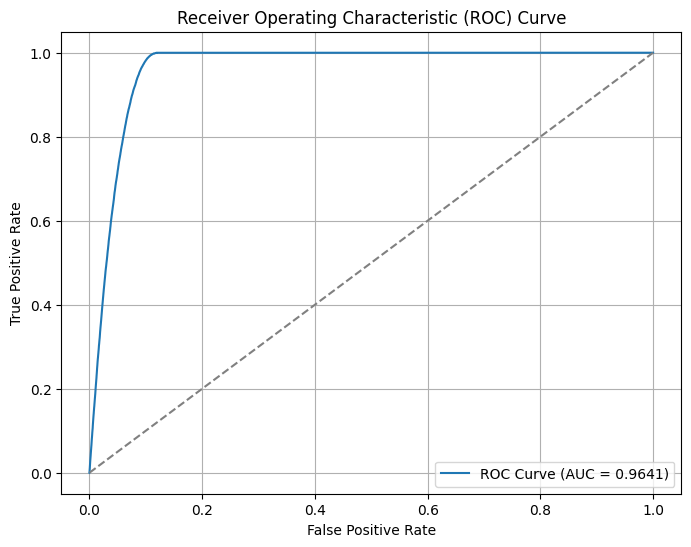

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()

Generate and plot the Precision-Recall Curve for the given true labels and predicted probabilities.

The Precision-Recall Curve is a graphical representation used to evaluate the performance of a binary classifier. 
It plots Precision (the ratio of true positive predictions to the total number of positive predictions) against Recall 
(the ratio of true positive predictions to the total number of actual positives) at various threshold settings. 

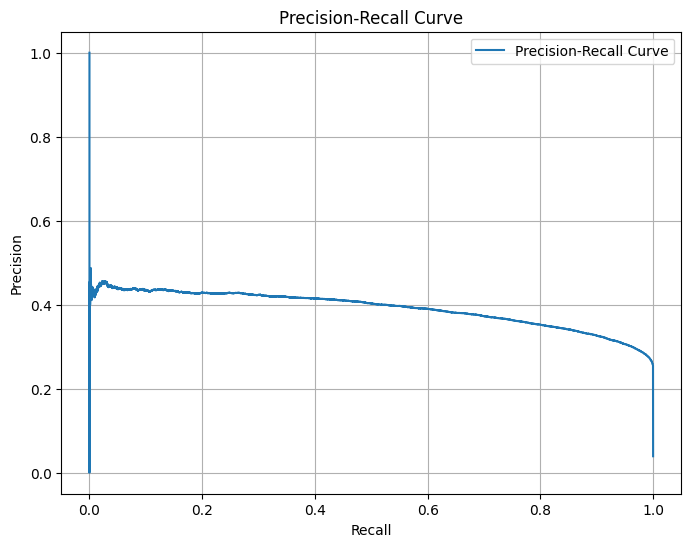

In [21]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

## Conclusions

In this notebook, we built a logistic regression model to predict whether a ray will trace successfully through a Cooke triplet lens system. Here are the key takeaways:

1. **Data Generation**: We generated 3 million random rays and traced them through the Cooke triplet lens system. The dataset was highly imbalanced, with only a small fraction of rays tracing successfully.

2. **Exploratory Data Analysis (EDA)**: Through EDA, we identified that the most critical parameter for successful ray tracing was the N direction cosine. This insight aligns with the intuition that rays pointing along the optical axis are more likely to trace successfully.

3. **Model Building**: We addressed the class imbalance using SMOTE and standardized the features before training the logistic regression model. The model was trained with a balanced class weight to further mitigate the imbalance issue.

4. **Model Performance**: The logistic regression model achieved high recall for both classes, indicating its effectiveness in identifying successful and unsuccessful rays. The ROC AUC score and precision-recall curve further demonstrated the model's ability to distinguish between the two classes.

5. **Visualization**: Various plots, including the correlation matrix, ROC curve, and precision-recall curve, provided insights into the model's performance and the relationships between features.

Overall, the logistic regression model performed well in predicting ray tracing success, and the methodology used in this notebook can be applied to similar optical systems and classification problems.